In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.path.append('../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.networks import ScoreNet
from sdebridge.utils import *

plt.style.use('ggplot')

In [72]:
def eval_Q(x: jnp.ndarray, t: float, alpha: float, sigma: float) -> jnp.ndarray:
    make_square = lambda Q: Q.reshape((jnp.sqrt(Q.size).astype('int32'), jnp.sqrt(Q.size).astype('int32')))
    k_Q = lambda x: 0.5 * (alpha**2) * (sigma**2) * jnp.pi * jnp.exp(-0.5 * jnp.sum(jnp.square(x), axis=2) / (sigma**2))
    k_Q_q = lambda x1, x2: k_Q(x1.reshape(-1, 2)[:, jnp.newaxis, :] - x2.reshape(-1, 2)[jnp.newaxis, :, :])
    Q = lambda x: make_square(jnp.einsum('ij,kl->ikjl', k_Q_q(x, x), jnp.eye(2)))
    return Q(x)

(32,)
(32, 32)


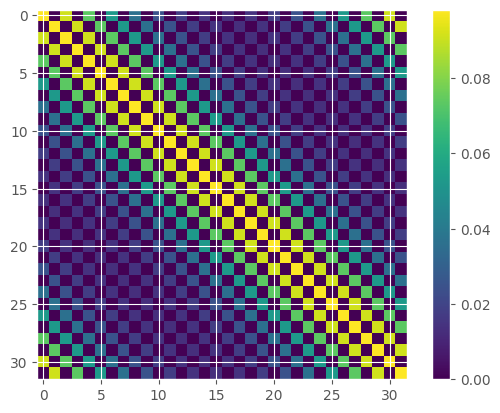

In [73]:
circles = sample_circle(num_points=16, scale=0.5, shifts=jnp.array([0.0, 0.0]))
print(circles.shape)
Q = eval_Q(circles, t=None, alpha=0.5, sigma=0.5)
print(Q.shape)
plt.imshow(Q)
plt.colorbar()

In [89]:
rng = jax.random.PRNGKey(0)

(1, 51, 64)


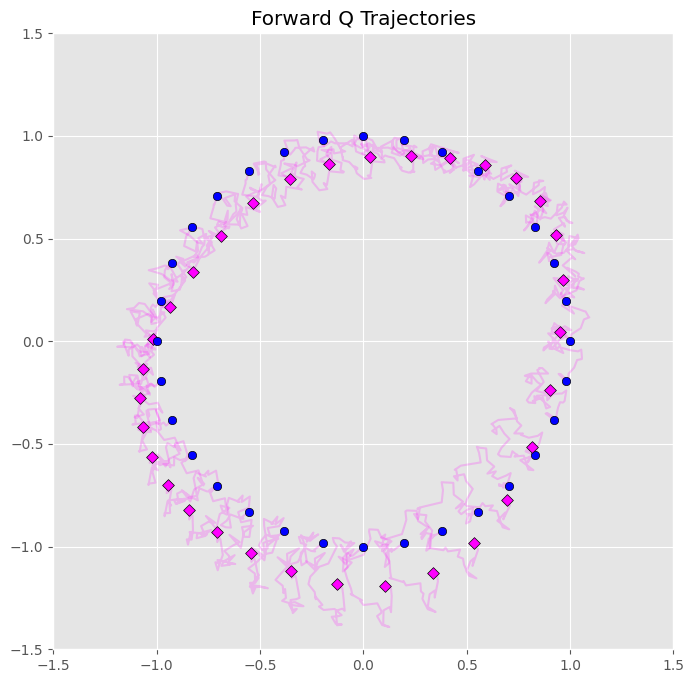

In [153]:
d = 64
alpha = 0.5
sigma = 0.5

circles = sample_circle(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
squares = sample_square(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
Q = eval_Q(circles, t=None, alpha=alpha, sigma=sigma)
rng, _ = jax.random.split(rng)

# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.scatter(circles.reshape(-1, 2)[:, 0], circles.reshape(-1, 2)[:, 1], color='b')
# ax.scatter(squares.reshape(-1, 2)[:, 0], squares.reshape(-1, 2)[:, 1], color='r')
# print(circles.shape, squares.shape)

def drift(val, time):
    return jnp.zeros(d)

def diffusion(val, time): 
    return Q 

model = DiffusionBridge(
    drift = drift,
    diffusion = diffusion,
    dim=d,
    end_time=1.0,
    num_steps=50,
    rng=rng
)

forward_brownian_motion = model.simulate_forward_process(initial_condition=jnp.tile(circles, reps=(1, 1)))
print(forward_brownian_motion["trajectories"].shape)
plot_trajectories(forward_brownian_motion["trajectories"], title="Forward Q Trajectories")

In [121]:
train_params = {"batch_size": 64, "num_epochs": 50, "num_batches_per_epoch": 50, "learning_rate": 1e-2}
score_transition_net = ScoreNet(out_dim=model.d,
                                time_embedding_dim=128,
                                embedding_dim=128,
                                act='leaky_relu',
                                encoder_layer_dims=[128, 128],
                                decoder_layer_dims=[128, 128],
                                using_batchnorm=True)
score_transition_state = model.learn_forward_transition_score(score_transition_net, 
                                                              initial_condition=circles, 
                                                              training_params=train_params)

Epoch 1 / 50: loss = 297.4885
Epoch 2 / 50: loss = 292.2266
Epoch 3 / 50: loss = 291.7608
Epoch 4 / 50: loss = 291.6625
Epoch 5 / 50: loss = 290.7943
Epoch 6 / 50: loss = 290.6778
Epoch 7 / 50: loss = 290.3681
Epoch 8 / 50: loss = 290.1003
Epoch 9 / 50: loss = 290.7066
Epoch 10 / 50: loss = 290.6536
Epoch 11 / 50: loss = 290.6884
Epoch 12 / 50: loss = 290.8037
Epoch 13 / 50: loss = 290.0419
Epoch 14 / 50: loss = 290.2137
Epoch 15 / 50: loss = 290.1848
Epoch 16 / 50: loss = 290.3038
Epoch 17 / 50: loss = 290.4137
Epoch 18 / 50: loss = 289.9595
Epoch 19 / 50: loss = 290.2601
Epoch 20 / 50: loss = 289.9037
Epoch 21 / 50: loss = 290.0488
Epoch 22 / 50: loss = 290.1842
Epoch 23 / 50: loss = 289.8726
Epoch 24 / 50: loss = 289.7847
Epoch 25 / 50: loss = 290.0523
Epoch 26 / 50: loss = 290.0122
Epoch 27 / 50: loss = 290.0533
Epoch 28 / 50: loss = 289.9607
Epoch 29 / 50: loss = 290.0286
Epoch 30 / 50: loss = 290.0051
Epoch 31 / 50: loss = 289.9071
Epoch 32 / 50: loss = 289.7448
Epoch 33 / 50: lo

(1, 51, 16)


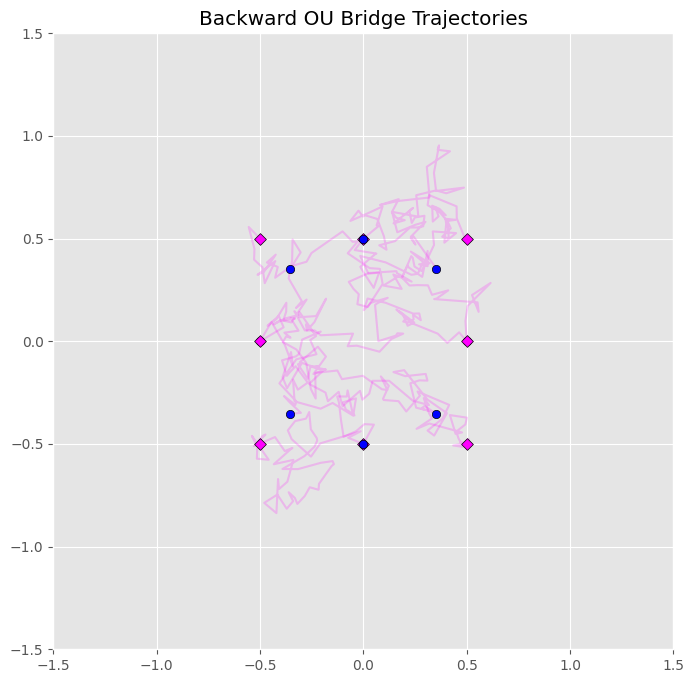

In [123]:
backward_brownian_bridge = model.simulate_backward_bridge(score_transition_state=score_transition_state, 
                                                            initial_condition=jnp.tile(squares, reps=(1, 1)), 
                                                            terminal_condition=jnp.tile(circles, reps=(1, 1)), 
                                                            using_true_score=False)
print(backward_brownian_bridge["trajectories"].shape)
plot_trajectories(backward_brownian_bridge["trajectories"], title="Backward OU Bridge Trajectories")